In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import re
import time

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
from nltk import word_tokenize
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from langdetect import detect_langs

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
import string
import lightgbm as lgb 
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, log_loss
from sklearn.metrics import roc_curve, auc, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

import sys
if not sys.warnoptions:
        import warnings
        #suppress warning messages (those with peach background)
        warnings.simplefilter("ignore")

In [2]:
# Widen width of notebook and increase dataframe dimensions
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [3]:
df=pd.read_csv('twitter_sentiment_data.csv')
df.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153


In [4]:
df=df.drop_duplicates('message',keep='first')
df=df.reset_index()

In [5]:
df.shape

(41033, 4)

sentiment distribution
 1    20599
 2     9073
 0     7505
-1     3856
Name: sentiment, dtype: int64


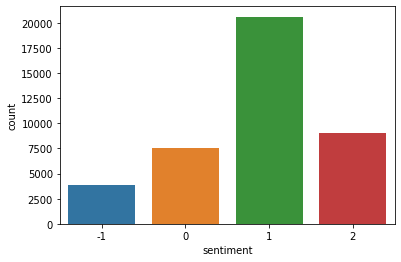

In [6]:
print('sentiment distribution')
print(df.sentiment.value_counts())
sns.countplot(x='sentiment', data=df)
plt.show()

In [7]:
# n=3856
# df_neg1=df.query('sentiment == -1')
# df_0=df.query('sentiment == 0')
# df_1=df.query('sentiment == 1')
# df_2=df.query('sentiment == 2')
# df=pd.concat([df_neg1,df_0, df_1,df_2])
# df=df.reset_index()
df.head()

,index,sentiment,message,tweetid
0,0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153


### Data Exploration

In [8]:
df.shape

(41033, 4)

In [9]:
df.sentiment.value_counts()

 1    20599
 2     9073
 0     7505
-1     3856
Name: sentiment, dtype: int64

In [10]:
df.isnull().sum()

index        0
sentiment    0
message      0
tweetid      0
dtype: int64

In [11]:
df.dtypes

index         int64
sentiment     int64
message      object
tweetid       int64
dtype: object

### Feature engineering

In [12]:
df['num_char'] = df['message'].str.len()
df['num_word'] = df['message'].str.split().map(lambda x: len(x))
df['ave_word_length'] = df['num_char'] / df['num_word'] 
df['punctuation_count'] = df["message"].apply(lambda x: len([w for w in str(x) if w in string.punctuation]) )
df['num_punctuation'] = df.message.str.count('[^\w\s]')

In [13]:
df.head()

,index,sentiment,message,tweetid,num_char,num_word,ave_word_length,punctuation_count,num_punctuation
0,0,-1,@tiniebeany climate change is an interesting h...,792927353886371840,137,24,5.708333,1,1
1,1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641,146,17,8.588235,10,14
2,2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256,117,14,8.357143,14,14
3,3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904,143,17,8.411765,9,12
4,4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153,139,21,6.619048,6,10


In [14]:
df.describe()

,index,sentiment,tweetid,num_char,num_word,ave_word_length,punctuation_count,num_punctuation
count,41033.000000,41033.000000,4.103300e+04,41033.000000,41033.000000,41033.000000,41033.000000,41033.000000
mean,23223.825921,0.850267,8.396000e+17,121.770307,17.221895,7.297338,7.680696,8.621378
std,12160.997367,0.870349,8.796252e+16,24.863776,4.640079,1.315061,3.579653,4.198512
min,0.000000,-1.000000,5.926334e+17,7.000000,1.000000,3.564103,0.000000,0.000000
25%,13147.000000,0.000000,7.976916e+17,109.000000,14.000000,6.363636,5.000000,6.000000
50%,23412.000000,1.000000,8.425096e+17,132.000000,18.000000,7.117647,7.000000,8.000000
75%,33673.000000,1.000000,9.063033e+17,140.000000,21.000000,8.000000,10.000000,11.000000
max,43942.000000,2.000000,9.667024e+17,623.000000,97.000000,37.000000,58.000000,185.000000


In [15]:
df.groupby('sentiment').describe()

index                                                     \
             count          mean           std  min      25%      50%   
sentiment                                                               
-1          3856.0  24874.957988  11779.817927  0.0  15047.0  24897.5   
 0          7505.0  25245.392538  12386.474574  5.0  15213.0  27378.0   
 1         20599.0  22837.634497  12217.488614  1.0  12508.0  23430.0   
 2          9073.0  21726.695360  11704.340412  4.0  12429.0  19879.0   

                              tweetid                              \
                75%      max    count          mean           std   
sentiment                                                           
-1         35387.75  43935.0   3856.0  8.331735e+17  9.382540e+16   
 0         35710.00  43941.0   7505.0  8.397551e+17  9.611857e+16   
 1         33188.50  43942.0  20599.0  8.444780e+17  8.542918e+16   
 2         31415.00  43940.0   9073.0  8.311281e+17  8.306112e+16   

                                                                   \
                    min           25%           50%           75%   
sentiment                                                           
-1         5.928605e+17  7.966736e+17  8.418629e+17  9.032513e+17   
 0         5.931511e+17  7.942349e+17  8.444006e+17  9.304307e+17   
 1         5.926334e+17  7.981225e+17  8.442876e+17  9.088773e+17   
 2         5.927030e+17  7.994719e+17  8.408264e+17  8.749595e+17   

                        num_char                                             \
                    max    count        mean        std   min    25%    50%   
sentiment                                                                     
-1         9.664135e+17   3856.0  123.668050  24.584353  22.0  114.0  135.0   
 0         9.666928e+17   7505.0  110.457295  33.800550   7.0   84.0  122.0   
 1         9.667024e+17  20599.0  126.590854  21.412491  22.0  118.0  136.0   
 2         9.659864e+17   9073.0  119.377273  19.681367  37.0  106.0  123.0   

                        num_word                                              \
             75%    max    count       mean       std  min   25%   50%   75%   
sentiment                                                                      
-1         140.0  172.0   3856.0  18.067687  4.662830  2.0  15.0  19.0  21.0   
 0         140.0  623.0   7505.0  16.217322  5.768529  1.0  12.0  17.0  21.0   
 1         140.0  208.0  20599.0  18.279237  4.273981  2.0  16.0  19.0  21.0   
 2         138.0  172.0   9073.0  15.292847  3.426748  3.0  13.0  15.0  18.0   

                ave_word_length                                          \
            max           count      mean       std       min       25%   
sentiment                                                                 
-1         30.0          3856.0  7.058134  1.261924  4.350000  6.216615   
 0         97.0          7505.0  7.090464  1.585713  4.137931  6.086957   
 1         39.0         20599.0  7.122267  1.209192  3.564103  6.285714   
 2         26.0          9073.0  7.967598  1.080231  4.840000  7.210526   

                                         punctuation_count            \
                50%       75%        max             count      mean   
sentiment                                                              
-1         6.833333  7.692308  24.000000            3856.0  7.529046   
 0         6.800000  7.777778  37.000000            7505.0  6.592139   
 1         6.952381  7.777778  23.333333           20599.0  7.552842   
 2         7.875000  8.666667  13.600000            9073.0  8.935854   

                                               num_punctuation            \
                std  min  25%  50%   75%   max           count      mean   
sentiment                                                                  
-1         3.641409  0.0  5.0  7.0  10.0  36.0          3856.0  8.436981   
 0         3.839333  0.0  4.0  6.0   9.0  25.0          7505.0  7.513125   
 1     

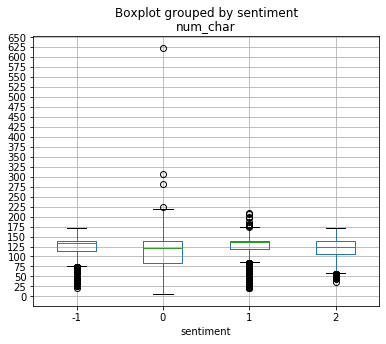

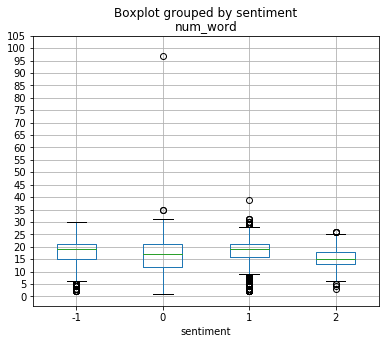

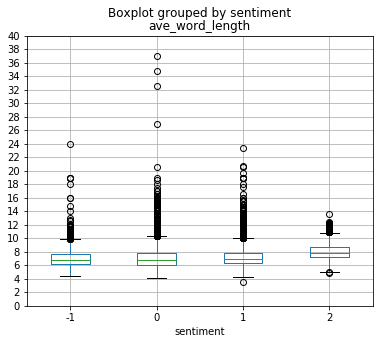

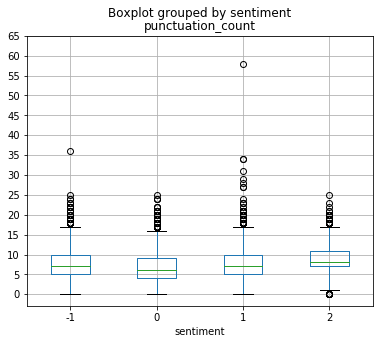

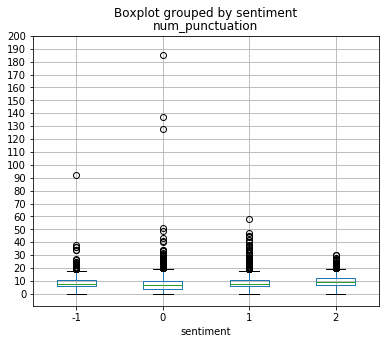

In [16]:
ax = df.boxplot('num_char', by='sentiment', rot=0, figsize=(6, 5))
ax.set_yticks(np.arange(0,675,step=25))
ax = df.boxplot('num_word', by='sentiment', rot=0, figsize=(6, 5))
ax.set_yticks(np.arange(0,106,step=5))
ax = df.boxplot('ave_word_length', by='sentiment', rot=0, figsize=(6, 5))
ax.set_yticks(np.arange(0,42,step=2))
ax = df.boxplot('punctuation_count', by='sentiment', rot=0, figsize=(6, 5))
ax.set_yticks(np.arange(0,66,step=5))
ax = df.boxplot('num_punctuation', by='sentiment', rot=0, figsize=(6, 5))
ax.set_yticks(np.arange(0,210,step=10))
plt.show()

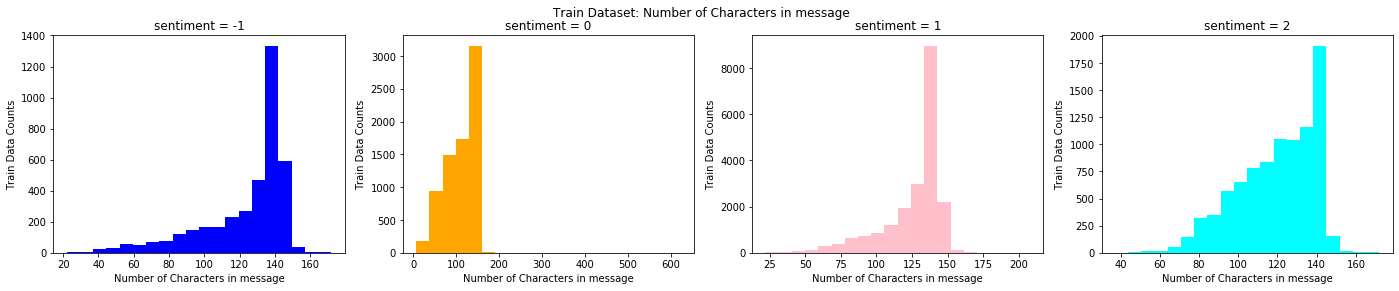

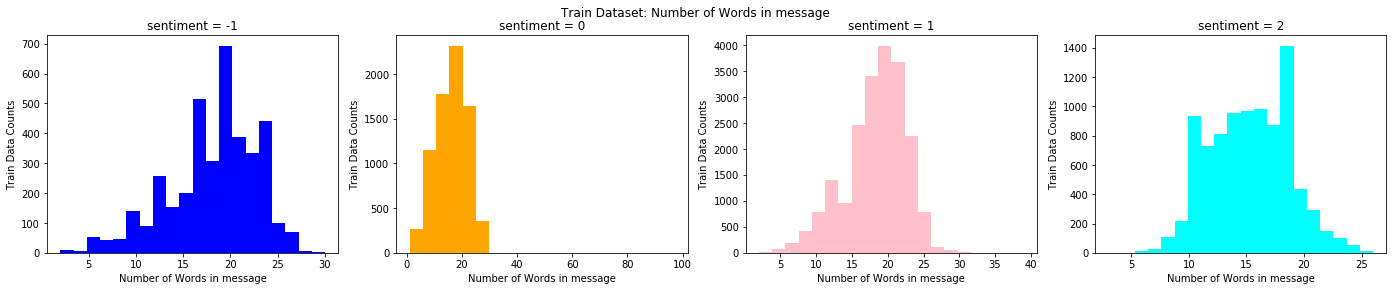

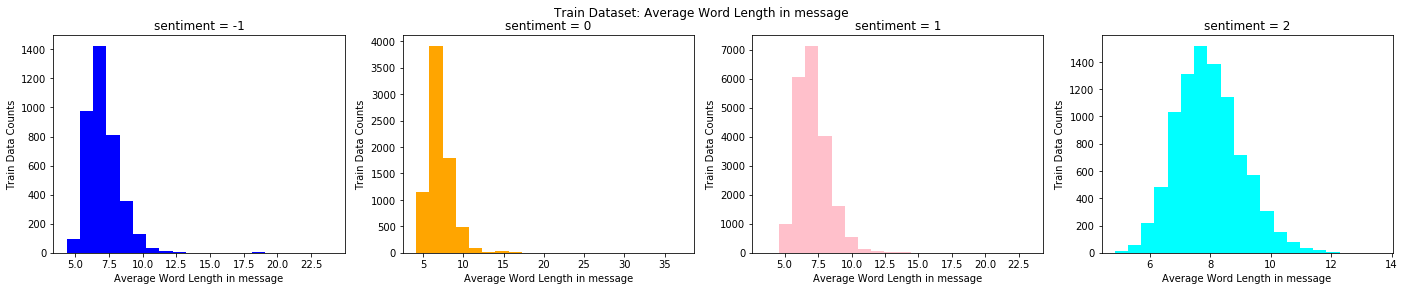

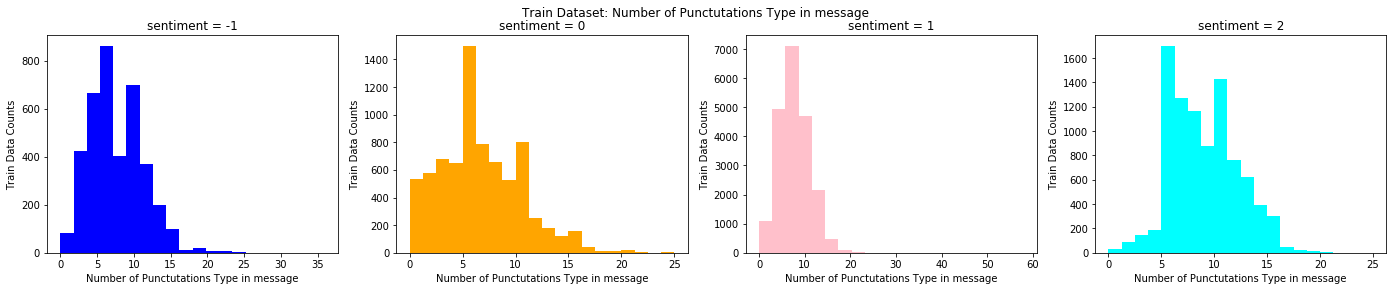

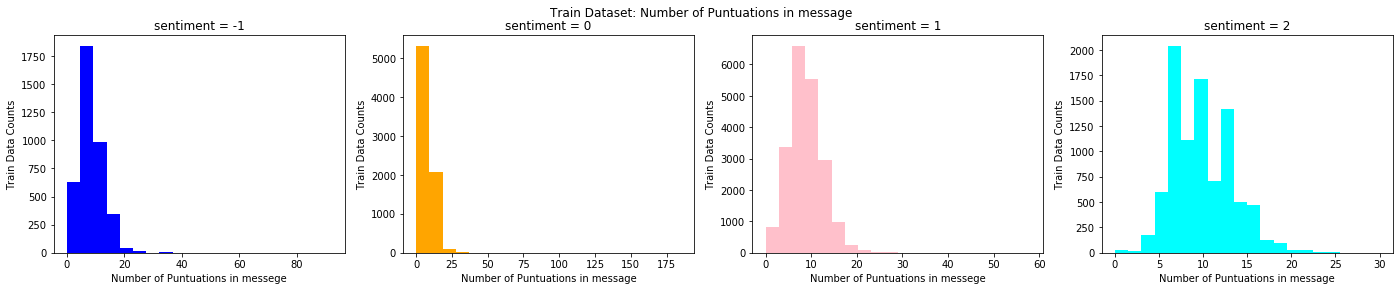

In [17]:
# Number of Characters in message
fig,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(24,4))
text_len=df[df['sentiment']==-1]['num_char']
ax1.hist(text_len,color='blue', bins=20)
ax1.set_title('sentiment = -1')
ax1.set_xlabel("Number of Characters in message") 
ax1.set_ylabel("Train Data Counts")
text_len=df[df['sentiment']==0]['num_char']
ax2.hist(text_len,color='orange', bins=20)
ax2.set_title('sentiment = 0')
ax2.set_xlabel("Number of Characters in message") 
ax2.set_ylabel("Train Data Counts")
fig.suptitle('Train Dataset: Number of Characters in message')
text_len=df[df['sentiment']==1]['num_char']
ax3.hist(text_len,color='pink', bins=20)
ax3.set_title('sentiment = 1')
ax3.set_xlabel("Number of Characters in message") 
ax3.set_ylabel("Train Data Counts")
fig.suptitle('Train Dataset: Number of Characters in message')
text_len=df[df['sentiment']==2]['num_char']
ax4.hist(text_len,color='cyan', bins=20)
ax4.set_title('sentiment = 2')
ax4.set_xlabel("Number of Characters in message") 
ax4.set_ylabel("Train Data Counts")
fig.suptitle('Train Dataset: Number of Characters in message')
plt.show()

# Number of Words in a message
fig,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(24,4))
text_len=df[df['sentiment']==-1]['num_word']
ax1.hist(text_len,color='blue', bins=20)
ax1.set_title('sentiment = -1')
ax1.set_xlabel("Number of Words in message") 
ax1.set_ylabel("Train Data Counts")
text_len=df[df['sentiment']==0]['num_word']
ax2.hist(text_len,color='orange', bins=20)
ax2.set_title('sentiment = 0')
ax2.set_xlabel("Number of Words in message") 
ax2.set_ylabel("Train Data Counts")
fig.suptitle('Train Dataset: Number of Words in message')
text_len=df[df['sentiment']==1]['num_word']
ax3.hist(text_len,color='pink', bins=20)
ax3.set_title('sentiment = 1')
ax3.set_xlabel("Number of Words in message") 
ax3.set_ylabel("Train Data Counts")
text_len=df[df['sentiment']==2]['num_word']
ax4.hist(text_len,color='cyan', bins=20)
ax4.set_title('sentiment = 2')
ax4.set_xlabel("Number of Words in message") 
ax4.set_ylabel("Train Data Counts")
fig.suptitle('Train Dataset: Number of Words in message')
plt.show()

# Average Word Length in a message
fig,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(24,4))
text_len=df[df['sentiment']==-1]['ave_word_length']
ax1.hist(text_len,color='blue', bins=20)
ax1.set_title('sentiment = -1')
ax1.set_xlabel("Average Word Length in message") 
ax1.set_ylabel("Train Data Counts")
text_len=df[df['sentiment']==0]['ave_word_length']
ax2.hist(text_len,color='orange', bins=20)
ax2.set_title('sentiment = 0')
ax2.set_xlabel("Average Word Length in message") 
ax2.set_ylabel("Train Data Counts")
fig.suptitle('Train Dataset: Average Word Length in message')
text_len=df[df['sentiment']==1]['ave_word_length']
ax3.hist(text_len,color='pink', bins=20)
ax3.set_title('sentiment = 1')
ax3.set_xlabel("Average Word Length in message") 
ax3.set_ylabel("Train Data Counts")
text_len=df[df['sentiment']==2]['ave_word_length']
ax4.hist(text_len,color='cyan', bins=20)
ax4.set_title('sentiment = 2')
ax4.set_xlabel("Average Word Length in message") 
ax4.set_ylabel("Train Data Counts")
fig.suptitle('Train Dataset: Average Word Length in message')
plt.show()

# Number type of Punctuations in a message
fig,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(24,4))
text_len=df[df['sentiment']==-1]['punctuation_count']
ax1.hist(text_len,color='blue', bins=20)
ax1.set_title('sentiment = -1')
ax1.set_xlabel("Number of Punctutations Type in message") 
ax1.set_ylabel("Train Data Counts")
text_len=df[df['sentiment']==0]['punctuation_count']
ax2.hist(text_len,color='orange', bins=20)
ax2.set_title('sentiment = 0')
ax2.set_xlabel("Number of Punctutations Type in message") 
ax2.set_ylabel("Train Data Counts")
fig.suptitle('Train Dataset: Type of Stopwords in message')
text_len=df[df['sentiment']==1]['punctuation_count']
ax3.hist(text_len,color='pink', bins=20)
ax3.set_title('sentiment = 1')
ax3.set_xlabel("Number of Punctutations Type in message") 
ax3.set_ylabel("Train Data Counts")
text_len=df[df['sentiment']==2]['punctuation_count']
ax4.hist(text_len,color='cyan', bins=20)
ax4.set_title('sentiment = 2')
ax4.set_xlabel("Number of Punctutations Type in message") 
ax4.set_ylabel("Train Data Counts")
fig.suptitle('Train Dataset: Number of Punctutations Type in message')
plt.show()

# Number of Puntuations in a message
fig,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(24,4))
text_len=df[df['sentiment']==-1]['num_punctuation']
ax1.hist(text_len,color='blue', bins=20)
ax1.set_title('sentiment = -1')
ax1.set_xlabel("Number of Puntuations in messege") 
ax1.set_ylabel("Train Data Counts")
text_len=df[df['sentiment']==0]['num_punctuation']
ax2.hist(text_len,color='orange', bins=20)
ax2.set_title('sentiment = 0')
ax2.set_xlabel("Number of Puntuations in message") 
ax2.set_ylabel("Train Data Counts")
fig.suptitle('Train Dataset: Number of Puntuations in message')
text_len=df[df['sentiment']==1]['num_punctuation']
ax3.hist(text_len,color='pink', bins=20)
ax3.set_title('sentiment = 1')
ax3.set_xlabel("Number of Puntuations in messege") 
ax3.set_ylabel("Train Data Counts")
text_len=df[df['sentiment']==2]['num_punctuation']
ax4.hist(text_len,color='cyan', bins=20)
ax4.set_title('sentiment = 2')
ax4.set_xlabel("Number of Puntuations in message") 
ax4.set_ylabel("Train Data Counts")
fig.suptitle('Train Dataset: Number of Puntuations in message')
plt.show()

### Text processing

In [18]:
#text processing steps definition

def html_tag_remover(text):
    soup = BeautifulSoup(text)
    text_out = soup.get_text()
    return text_out

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

# def stopwords_remove(text):
#     STOPWORDS = set(stopwords.words('english'))
#     text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
#     return text

def CleanMessage(df):
    df['message'] = df.message.apply(lambda x:html_tag_remover(x))
   # df['message']=df['message'].apply(lambda x : remove_html(x)) # Remove HTML
    df['message']=df['message'].apply(lambda x : remove_URL(x)) 
    
    df['message'] = df['message'].str.lower()
    df['message'] = df['message'].str.replace(r'[^a-z]+',' ')
    df['message'] = df['message'].str.replace(r'[\s+]', ' ')

    df['message'] = df['message'].str.replace('leonardo','dicaprio')
    df['message'] = df['message'].str.replace('leodicaprio','dicaprio')
    df['message'] = df['message'].str.replace('leo','dicaprio')
#     df['message'] = df['message'].apply(stopwords_remove) #stopwords
    print('The messages have been cleaned')
    #return df           

def Lemma(df):
    df['message_toc']=[word_tokenize(text) for text in df['message']]
    WNLemmatizer=WordNetLemmatizer()
    df['message_lem']=[[WNLemmatizer.lemmatize(word) for word in token] for token in df['message_toc']]
    df['message_len_str'] = df.message_lem.astype(str)  
    print('The messages have been tokenized and lemmatized')
    return df

def WorldCloudBuilt(df):
    text=df['message'].str.cat()
    my_stopwords=set(STOPWORDS)
    my_stopwords.update(['many','will','via','thing','one','say','rt','https rt'])
    text=WordCloud(background_color="white",max_words=100, stopwords=my_stopwords).generate(text)
    
    plt.figure(figsize=(20,10))
    plt.imshow(text, interpolation='bilinear')
    plt.axis('off')
    plt.show()   
    
def WorldCloudBuilt_USA(df):
    usa_map = np.array(Image.open("hiclipart_usa_map.png"))  
    text=df['message'].str.cat()
    my_stopwords=set(STOPWORDS)
    my_stopwords.update(['many','will','via','thing','one','say','rt','https rt'])
    wordcloud = WordCloud(
        background_color = 'white', 
        mode = "RGBA",
        max_words = 2000,
        mask=usa_map,
        stopwords = my_stopwords).generate(str(text))

    plt.figure(figsize = (21, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    wordcloud.to_file('usa_map_wordcloud_white.png')
    
    wordcloud_black = WordCloud(
    background_color = 'black', 
    mode = "RGBA",
    max_words = 2000,
    mask=usa_map,
    stopwords = my_stopwords).generate(str(text))

    plt.figure(figsize = (20, 10))
    plt.imshow(wordcloud_black, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    wordcloud.to_file('usa_map_wordcloud_Black.png')

The messages have been cleaned
The messages have been tokenized and lemmatized

Fist 1000 strings after cleaning: 
 tiniebeany climate change is an interesting hustle as it was global warming but the planet stopped warming for yes while the suv boomrt natgeochannel watch beforetheflood right here as dicaprio travels the world to tackle climate change htt fabulous dicaprio dicaprio s film on climate change is brilliant do watch via youtubert mick fanning just watched this amazing documentary by dicapriodicaprio on climate change we all think this rt cnalive pranita biswasi a lutheran from odisha gives testimony on effects of climate change natural disasters on the po unamshow awache kujinga na iko global warming rt cciriviera presidential candidate donaldtrump is dangerous on climate change says monaco s prince albert rt americanindian dicaprio dicaprio s climate change documentary is free for a week indigenous tairp  beforetheflood watch beforetheflood right here as dicaprio travels th

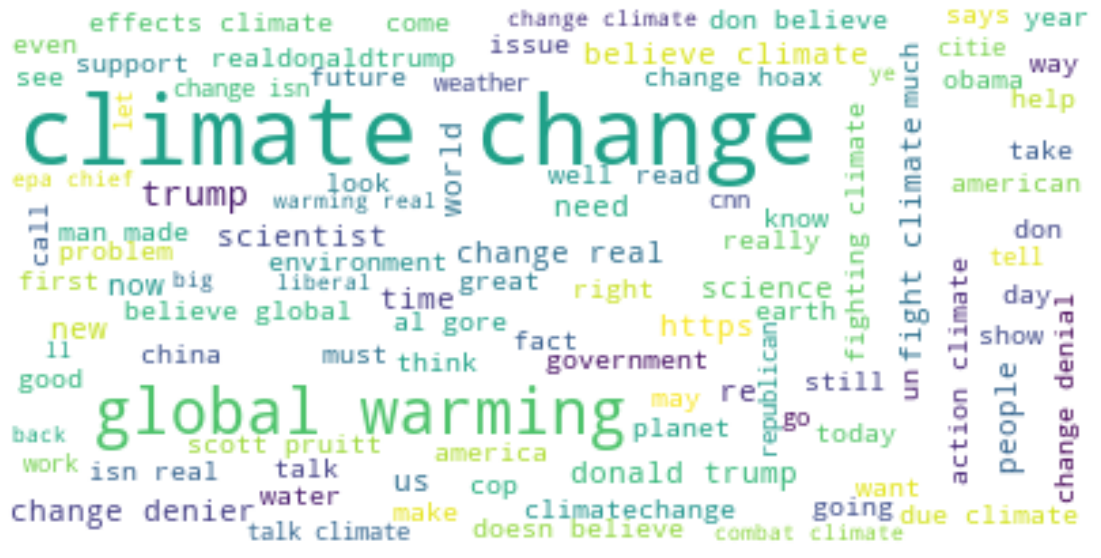

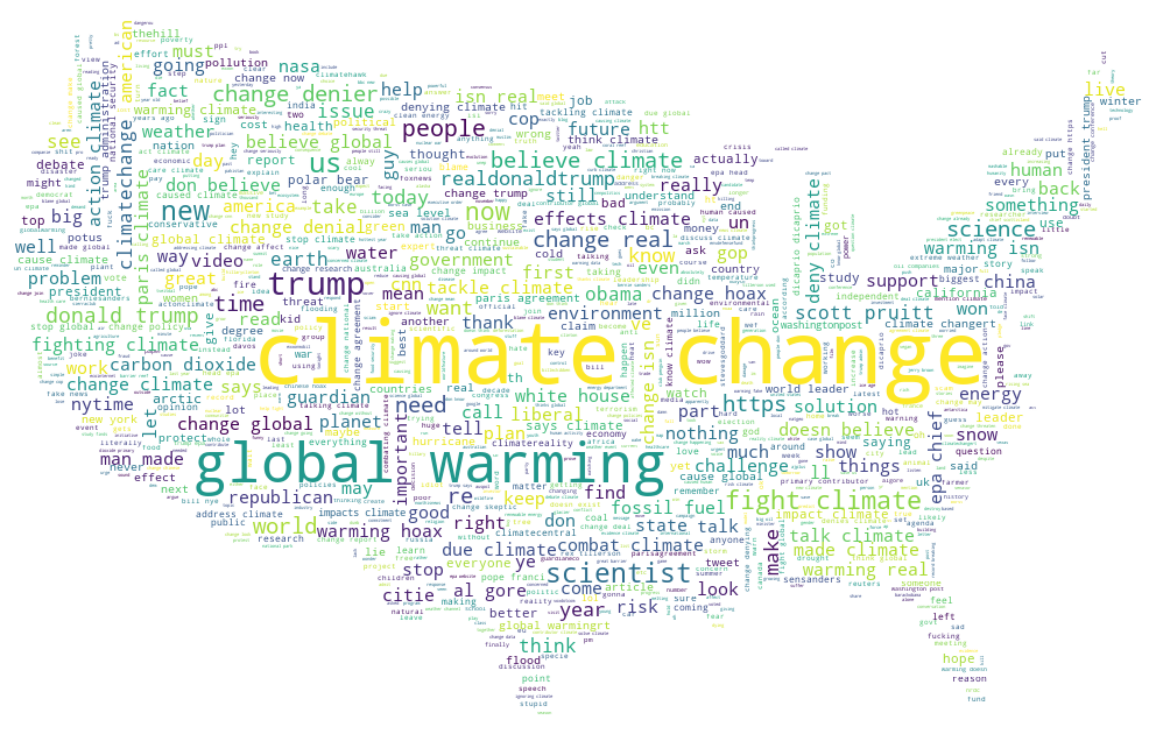

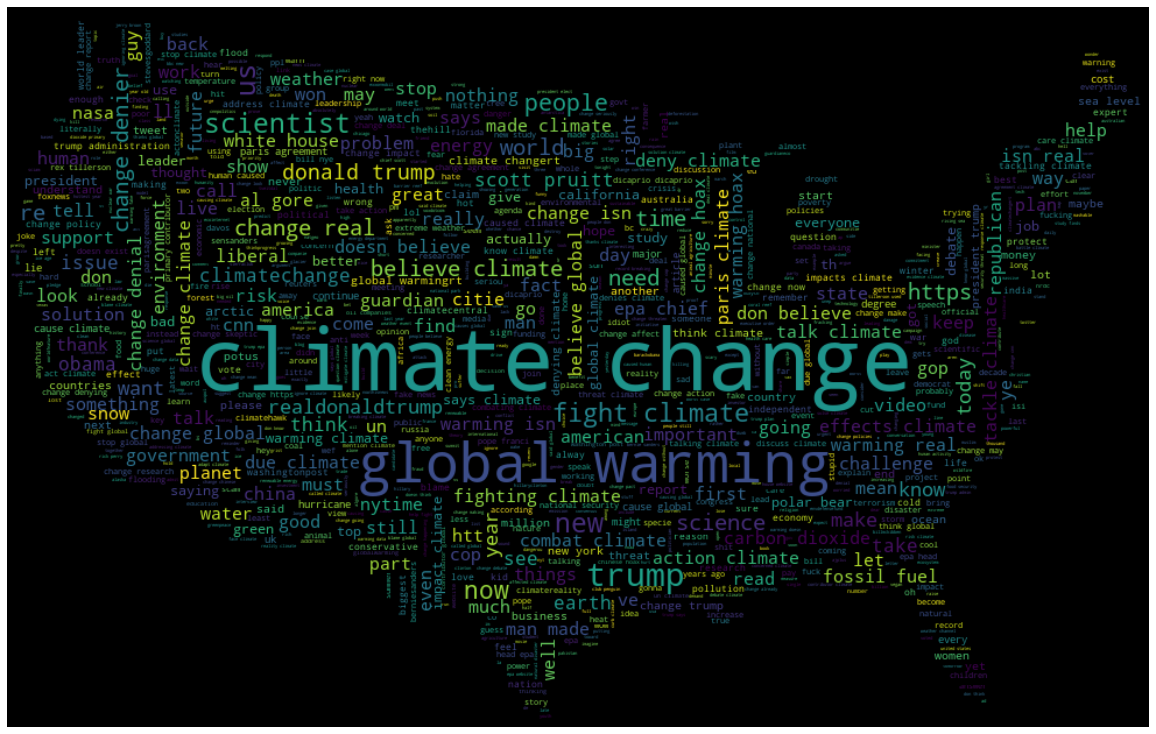

In [19]:
# text processing  for Kaggle dataset
CleanMessage(df)
Lemma(df)
print('\nFist 1000 strings after cleaning: ')
print(df['message'].str.cat()[:1000])
WorldCloudBuilt(df)
WorldCloudBuilt_USA(df)

In [20]:
#other than english language detection

languages=[]
rows_error=[]
for row in range(len(df)):
    try:
        languages.append(detect_langs(df.loc[row,'message']))
    except:
        language = "error"
        rows_error.append(row)
            
str(languages[0]).split(':')
str(languages[0]).split(':')[0]
str(languages[0]).split(':')[0][1:]
languages=[str(lang).split(':')[0][1:] for lang in languages]
    
df=df.drop(rows_error,axis=0)
    
df['language']=languages
df = df[df.language =='en']
print('The messages in other than english languagge have been removed. The dataset has',df.shape[0],'rows.')

The messages in other than english languagge have been removed. The dataset has 40221 rows.


In [21]:
df.to_csv('kaggleTweets_cleaned_full_dupl.csv')

### Converting text to vectors

In [22]:
df_copy = df.copy()
X=df_copy.message_len_str.to_list()
y=df_copy.sentiment.to_list()

logreg=LogisticRegression()
vect=CountVectorizer()

vect=CountVectorizer()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10,stratify=y)
X_train_vect=vect.fit_transform(X_train)
X_test_vect=vect.transform(X_test)

print(vect.get_feature_names()[:10])

['aa', 'aaa', 'aaaaaaaaa', 'aaaaaand', 'aaaaand', 'aaaand', 'aachixathif', 'aag', 'aalicesayss', 'aamir']


In [23]:
X_train_vect.shape

(32176, 35749)

In [24]:
logreg.fit(X_train_vect, y_train)
print('accuracy on training data: ', logreg.score(X_train_vect, y_train))
print('accuracy on testing data: ',accuracy_score(y_test, logreg.predict(X_test_vect)))

class_report=classification_report(y_test, logreg.predict(X_test_vect))
print('\nClassification report for Logistic Regression alogorithm: \n')
print(class_report)

accuracy on training data:  0.9186660865241174
accuracy on testing data:  0.7108763206960845

Classification report for Logistic Regression alogorithm: 

              precision    recall  f1-score   support

          -1       0.68      0.50      0.58       762
           0       0.56      0.43      0.49      1409
           1       0.74      0.83      0.78      4087
           2       0.74      0.75      0.75      1787

    accuracy                           0.71      8045
   macro avg       0.68      0.63      0.65      8045
weighted avg       0.70      0.71      0.70      8045



### Model testing with K-fold validation

In [25]:
#df=pd.read_csv('kaggleTweets_cleaned.csv')
#print(df.shape)
#df.head()

In [26]:
df_copy = df.copy()
X=df_copy.message_len_str.to_list()
y=df_copy.sentiment.to_list()

### CountVectorizer

In [27]:
#with CountVectorizer
logreg = LogisticRegression(random_state=10)
knn = KNeighborsClassifier(n_neighbors=3)
nb = MultinomialNB()
svm = SVC(random_state=10)
DecisionTree = DecisionTreeClassifier(random_state=10)
RandomForest = RandomForestClassifier(random_state=10)
adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=100,random_state=10)
XGB = XGBClassifier(n_estimators  = 100, objective='multi:softmax',seed=10)
LGBM = LGBMClassifier(n_estimator=100, max_depth=10, min_data_in_leaf=20, 
                            num_leaves=50, objective = 'multiclassova', random_state=10)

models=[logreg,knn,nb,DecisionTree, svm, RandomForest,adaboost,XGB,LGBM]
# models=[logreg,knn,nb,DecisionTree, RandomForest,adaboost,XGB,LGBM]
kfold=StratifiedKFold(n_splits=5,random_state=10)

model_score=[]
mean_score=[]
std_score=[]
for model in models:
    vect=CountVectorizer()
    pipe = make_pipeline(vect,model)
    score=cross_val_score(pipe,X, y, cv=kfold, scoring='f1_weighted',n_jobs=4, verbose=1)
    model_score.append(score)
    mean_score.append(score.mean())
    std_score.append(score.std())

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   25.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   46.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   58.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 23.9min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  7.5min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   

In [28]:
print('with CountVectorizer, full dataset')
model_score_df=pd.DataFrame(model_score,index=['LogisticRegression','KNN','NaiveBayes','DecisionTree','SVM','RandomForest','AdaBoost','XGB','LGBM'], columns=['fold-1','fold-2','fold-3','fold-4','fold-5',])
mean_score_df=pd.DataFrame(mean_score,index=['LogisticRegression','KNN','NaiveBayes','DecisionTree','SVM','RandomForest','AdaBoost','XGB','LGBM'], columns=['mean_score'])
std_score_df=pd.DataFrame(std_score,index=['LogisticRegression','KNN','NaiveBayes','DecisionTree','SVM','RandomForest','AdaBoost','XGB','LGBM'],columns=['std_score'])

#model_results=pd.concat([model_score_df,mean_score_df,std_score_df,], axis=1)
model_results=pd.concat([mean_score_df,std_score_df,], axis=1)
print(model_results)

with CountVectorizer, full dataset
                    mean_score  std_score
LogisticRegression    0.673532   0.011433
KNN                   0.363777   0.015432
NaiveBayes            0.627280   0.006619
DecisionTree          0.537750   0.012445
SVM                   0.654926   0.012027
RandomForest          0.593644   0.008890
AdaBoost              0.572984   0.012717
XGB                   0.534550   0.012718
LGBM                       NaN        NaN


### TfidfVectorizer

In [29]:
#with TfidfVectorizer
model_score=[]
mean_score=[]
std_score=[]
for model in models:
    vect=TfidfVectorizer()
    pipe = make_pipeline(vect,model)
    score=cross_val_score(pipe,X, y, cv=kfold, scoring='f1_weighted',n_jobs=4, verbose=1)
    model_score.append(score)
    mean_score.append(score.mean())
    std_score.append(score.std())

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   16.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   40.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   57.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 33.3min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  5.9min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   

In [30]:
print('with TfidfVectorizer, full dataset')
model_score_df=pd.DataFrame(model_score,index=['LogisticRegression','KNN','NaiveBayes','DecisionTree','SVM','RandomForest','AdaBoost','XGB','LGBM'], columns=['fold-1','fold-2','fold-3','fold-4','fold-5',])
mean_score_df=pd.DataFrame(mean_score,index=['LogisticRegression','KNN','NaiveBayes','DecisionTree','SVM','RandomForest','AdaBoost','XGB','LGBM'], columns=['mean_score'])
std_score_df=pd.DataFrame(std_score,index=['LogisticRegression','KNN','NaiveBayes','DecisionTree','SVM','RandomForest','AdaBoost','XGB','LGBM'],columns=['std_score'])

#model_results=pd.concat([model_score_df,mean_score_df,std_score_df,], axis=1)
model_results=pd.concat([mean_score_df,std_score_df,], axis=1)
print(model_results)

with TfidfVectorizer, full dataset
                    mean_score  std_score
LogisticRegression    0.667433   0.009886
KNN                   0.536078   0.012986
NaiveBayes            0.448015   0.011033
DecisionTree          0.515162   0.010590
SVM                   0.658022   0.011034
RandomForest          0.589232   0.013605
AdaBoost              0.570661   0.019606
XGB                   0.561063   0.010499
LGBM                  0.619719   0.011911


In [31]:
#with TfidfVectorizer
model_score=[]
mean_score=[]
std_score=[]
for model in models:
    vect=TfidfVectorizer()
    pipe = make_pipeline(vect,model)
    score=cross_val_score(pipe,X, y, cv=kfold, scoring='accuracy',n_jobs=4, verbose=1)
    model_score.append(score)
    mean_score.append(score.mean())
    std_score.append(score.std())

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   16.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   40.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   57.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 33.4min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  5.8min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   

In [32]:
print('with TfidfVectorizer, full dataset')
model_score_df=pd.DataFrame(model_score,index=['LogisticRegression','KNN','NaiveBayes','DecisionTree','SVM','RandomForest','AdaBoost','XGB','LGBM'], columns=['fold-1','fold-2','fold-3','fold-4','fold-5',])
mean_score_df=pd.DataFrame(mean_score,index=['LogisticRegression','KNN','NaiveBayes','DecisionTree','SVM','RandomForest','AdaBoost','XGB','LGBM'], columns=['mean_score'])
std_score_df=pd.DataFrame(std_score,index=['LogisticRegression','KNN','NaiveBayes','DecisionTree','SVM','RandomForest','AdaBoost','XGB','LGBM'],columns=['std_score'])

#model_results=pd.concat([model_score_df,mean_score_df,std_score_df,], axis=1)
model_results=pd.concat([mean_score_df,std_score_df,], axis=1)
print(model_results)

with TfidfVectorizer, full dataset
                    mean_score  std_score
LogisticRegression    0.685189   0.008278
KNN                   0.531861   0.012716
NaiveBayes            0.561771   0.006529
DecisionTree          0.522563   0.009842
SVM                   0.682106   0.007589
RandomForest          0.633376   0.010592
AdaBoost              0.598965   0.018173
XGB                   0.607245   0.010801
LGBM                  0.647672   0.010893


## <span style="color:green"> LightGBM: Tuning</span> ##

In [33]:
# class TextSelector(BaseEstimator, TransformerMixin):
#     """
#     Transformer to select a single column from the data frame to perform additional transformations on
#     Use on text columns in the data
#     """
#     def __init__(self, key):
#         self.key = key

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         return X[self.key]
    
# class NumberSelector(BaseEstimator, TransformerMixin):
#     """
#     Transformer to select a single column from the data frame to perform additional transformations on
#     Use on numeric columns in the data
#     """
#     def __init__(self, key):
#         self.key = key

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         return X[[self.key]]

In [34]:
# text = Pipeline([
#                 ('selector', TextSelector(key='message')),
#                 ('tfidf', TfidfVectorizer())
#             ])

In [35]:
# num_char =  Pipeline([
#                 ('selector', NumberSelector(key='num_char')),
#                 ('standard', MinMaxScaler())
#             ])
# num_word =  Pipeline([
#                 ('selector', NumberSelector(key='num_word')),
#                 ('standard', MinMaxScaler())
#             ])
# ave_word_length =  Pipeline([
#                 ('selector', NumberSelector(key='ave_word_length')),
#                 ('standard', MinMaxScaler())
#             ])
# punctuation_count =  Pipeline([
#                 ('selector', NumberSelector(key='punctuation_count')),
#                 ('standard', MinMaxScaler())
#             ])
# num_punctuation =  Pipeline([
#                 ('selector', NumberSelector(key='num_punctuation')),
#                 ('standard', MinMaxScaler())    
#             ])

In [36]:
# feats = FeatureUnion([('text', text), 
#                       ('num_char', num_char),
#                       ('num_word', num_word),
#                       ('ave_word_length', ave_word_length),
#                      ('punctuation_count', punctuation_count),
#                      ('num_punctuation', num_punctuation)])

In [37]:
# lgb_class = LGBMClassifier()

# pipeline = Pipeline([
#     ('features',feats),
#     ('classifier', LGBMClassifier(objective = 'multiclassova', metric = 'multi_logloss', num_classes = 4))
# ])

In [38]:
# # For LGBMClassifier
# tuned_parameters = {
#     'features__text__tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
#     'features__text__tfidf__use_idf': (True, False),
#     'features__text__tfidf__norm': ('l1','l2'),
#     'classifier__max_depth': [5, 10, 20],
#     'classifier__num_leaves': [10, 30, 50, 70, 90],
#     'classifier__min_data_in_leaf': [10, 20, 50],
# }

# # 'features__text__tfidf__max_features': [1000, 3000, 5000],

In [39]:
lgb_class = LGBMClassifier()

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', LGBMClassifier(objective = 'multiclassova', metric = 'multi_logloss', num_classes = 4))
])

In [40]:
# For LGBMClassifier
tuned_parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1','l2'),
    'classifier__max_depth': [10, 20],
    'classifier__num_leaves': [10, 30, 50],
    'classifier__min_data_in_leaf': [10, 20],
}

# 'features__text__tfidf__max_features': [1000, 3000, 5000],

In [41]:
score = 'f1_weighted'
print("# Tuning hyper-parameters for %s" % score)
print()
np.errstate(divide='ignore')

clf = GridSearchCV(pipeline, tuned_parameters, cv=5, scoring=score, n_jobs=4, verbose = True)
%time clf.fit(X_train, y_train)

print("Best parameters set found on development set:"'\n')
print(clf.best_params_)

print()
print("Grid scores on development set:")
print()
for mean, std, params in zip(clf.cv_results_['mean_test_score'], 
                             clf.cv_results_['std_test_score'], 
                             clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


# Tuning hyper-parameters for f1_weighted

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  5.7min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 27.6min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 60.5min
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed: 119.7min finished


Wall time: 2h 19s
Best parameters set found on development set:

{'classifier__max_depth': 20, 'classifier__min_data_in_leaf': 10, 'classifier__num_leaves': 50, 'tfidf__ngram_range': (1, 2), 'tfidf__norm': 'l1', 'tfidf__use_idf': False}

Grid scores on development set:

0.626 (+/-0.009) for {'classifier__max_depth': 10, 'classifier__min_data_in_leaf': 10, 'classifier__num_leaves': 10, 'tfidf__ngram_range': (1, 1), 'tfidf__norm': 'l1', 'tfidf__use_idf': True}
0.628 (+/-0.009) for {'classifier__max_depth': 10, 'classifier__min_data_in_leaf': 10, 'classifier__num_leaves': 10, 'tfidf__ngram_range': (1, 1), 'tfidf__norm': 'l1', 'tfidf__use_idf': False}
0.621 (+/-0.010) for {'classifier__max_depth': 10, 'classifier__min_data_in_leaf': 10, 'classifier__num_leaves': 10, 'tfidf__ngram_range': (1, 1), 'tfidf__norm': 'l2', 'tfidf__use_idf': True}
0.624 (+/-0.009) for {'classifier__max_depth': 10, 'classifier__min_data_in_leaf': 10, 'classifier__num_leaves': 10, 'tfidf__ngram_range': (1, 1), 'tfid

In [42]:
clf.best_params_
clf.refit
print("Detailed classification report:")
print(classification_report(y_test, clf.predict(X_test), digits=4))

Detailed classification report:
              precision    recall  f1-score   support

          -1     0.7769    0.3793    0.5097       762
           0     0.5878    0.3683    0.4529      1409
           1     0.7126    0.8204    0.7627      4087
           2     0.6484    0.7566    0.6983      1787

    accuracy                         0.6853      8045
   macro avg     0.6814    0.5811    0.6059      8045
weighted avg     0.6826    0.6853    0.6702      8045



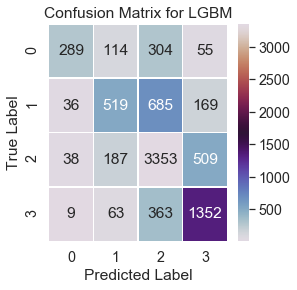

In [43]:
# Plot confusion matrix 
logreg_matrix = confusion_matrix(y_true=y_test, y_pred=clf.predict(X_test))
sns.set(font_scale=1.3)
plt.subplots(figsize=(4, 4))
sns.heatmap(logreg_matrix, annot=True, cbar=True, cmap='twilight',linewidth=0.5,fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for LGBM');

In [44]:
# score = 'accuracy'
# print("# Tuning hyper-parameters for %s" % score)
# print()
# np.errstate(divide='ignore')

# clf = GridSearchCV(pipeline, tuned_parameters, cv=5, scoring=score, n_jobs=4, verbose = True)
# %time clf.fit(X_train, y_train)

# print("Best parameters set found on development set:"'\n')
# print(clf.best_params_)

# print()
# print("Grid scores on development set:")
# print()
# for mean, std, params in zip(clf.cv_results_['mean_test_score'], 
#                              clf.cv_results_['std_test_score'], 
#                              clf.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

In [45]:
# clf.best_params_
# clf.refit
# print("Detailed classification report:")
# print(classification_report(y_test, clf.predict(X_test), digits=4))

In [46]:
# # Plot confusion matrix 
# logreg_matrix = confusion_matrix(y_true=y_test, y_pred=clf.predict(X_test))
# sns.set(font_scale=1.3)
# plt.subplots(figsize=(4, 4))
# sns.heatmap(logreg_matrix, annot=True, cbar=True, cmap='twilight',linewidth=0.5,fmt="d")
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.title('Confusion Matrix for LGBM');